In [1]:
import cftime
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from scipy.stats import genextreme as gev
from scipy import stats
import xclim as xc
from xclim import sdba
from xclim.sdba import nbutils

from unseen import fileio
from unseen import eva
from unseen import moments
from unseen import similarity
from unseen import stability
from unseen import bias_correction
from unseen import time_utils

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xclim/sdba/__init__.py:22: FutureWarning: The SDBA submodule is in the process of being split from `xclim` in order to facilitate development and effective maintenance of the SDBA utilities. The `xclim.sdba` functionality will change in the future. For more information, please visit https://xsdba.readthedocs.io/en/latest/.
  warnings.warn(


In [2]:
lat = {}
lon = {}

lat['Katherine'] = -14.5
lon['Katherine'] = 132.3

lat['Surat'] = -27.2
lon['Surat'] = 149.1

lat['Miena'] = -42.0
lon['Miena'] = 146.7

In [3]:
location = 'Katherine'

### Observations

In [4]:
rx1day_obs_file = '/Users/irv033/Desktop/unseen-bias/rx1day_AGCD-CSIRO_1901-2024_annual-jul-to-jun_AUS300i.nc'

In [5]:
ds_obs = fileio.open_dataset(rx1day_obs_file)

In [6]:
da_obs = ds_obs['pr'].sel({'lat': lat[location], 'lon': lon[location]}, method='nearest')

In [7]:
da_obs = da_obs.compute()

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xstatstests/scipy.py:246: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  outputs = func(args, **scipy_kwargs)


In [8]:
df_obs = da_obs.to_dataframe()

In [9]:
ranked_years = df_obs.sort_values(by='pr', ascending=False)
print(ranked_years.head(n=10))

                      lat    lon  event_time          pr
time                                                    
2016-06-30 00:00:00 -15.0  131.5  2015-12-26  121.034966
1957-06-30 00:00:00 -15.0  131.5  1957-03-07  117.113503
1998-06-30 00:00:00 -15.0  131.5  1998-01-27  108.367790
1937-06-30 00:00:00 -15.0  131.5  1937-01-07   79.655670
2000-06-30 00:00:00 -15.0  131.5  2000-03-03   75.046738
1914-06-30 00:00:00 -15.0  131.5  1914-01-04   74.041893
1916-06-30 00:00:00 -15.0  131.5  1915-12-24   73.600754
2005-06-30 00:00:00 -15.0  131.5  2005-01-01   70.866669
2004-06-30 00:00:00 -15.0  131.5  2003-12-23   69.717285
1946-06-30 00:00:00 -15.0  131.5  1946-02-15   69.121651


In [10]:
linear_fit_obs = np.polyfit(da_obs.time.dt.year.values, da_obs.values, 1)
linear_data_obs = np.polyval(linear_fit_obs, da_obs.time.dt.year.values)

In [11]:
base_mean_obs = da_obs.sel(time=slice('1972-01-01', '2018-12-31')).mean().values

In [12]:
da_obs_detrended = (da_obs - linear_data_obs) + base_mean_obs
da_obs_detrended.attrs = da_obs.attrs

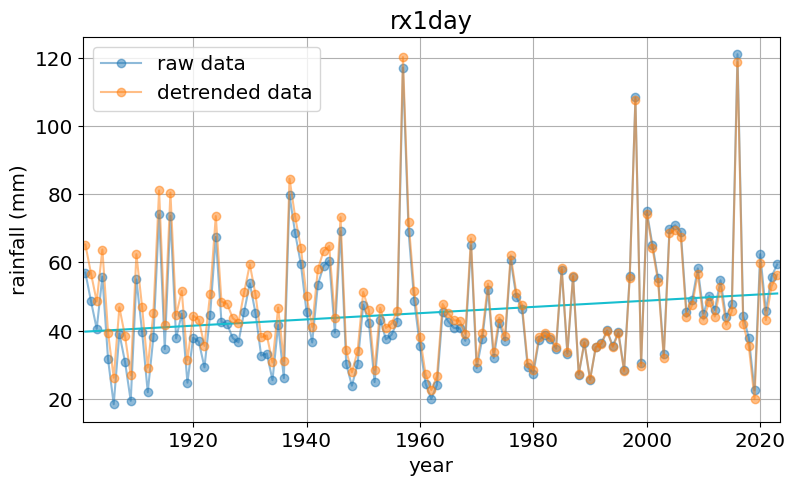

In [13]:
fig, ax = plt.subplots(figsize=[9, 5])
years = da_obs['time'].dt.year.values
plt.plot(years, da_obs.values, marker='o', label='raw data', color='tab:blue', alpha=0.5)
plt.plot(years, linear_data_obs, color='tab:cyan')
plt.plot(years, da_obs_detrended.values, marker='o', label='detrended data', color='tab:orange', alpha=0.5)
plt.xlim(years[0] - 0.5, years[-1] + 0.5)
plt.title('rx1day')
plt.ylabel('rainfall (mm)')
plt.xlabel('year')
plt.legend()
plt.grid()

In [14]:
gev_shape_obs_detrended, gev_loc_obs_detrended, gev_scale_obs_detrended = eva.fit_gev(da_obs_detrended.values)
print(f'Shape parameter: {gev_shape_obs_detrended:.2f}')
print(f'Location parameter: {gev_loc_obs_detrended:.2f}')
print(f'Scale parameter: {gev_scale_obs_detrended:.2f}')

Shape parameter: -0.07
Location parameter: 40.01
Scale parameter: 12.15


### Model data

In [15]:
rx1day_model_file = '/Users/irv033/Desktop/unseen-bias/rx1day_CanESM5-dcppA-hindcast_196101-201701_annual-jul-to-jun_AUS300i.nc'

In [16]:
ds_model = fileio.open_dataset(rx1day_model_file)

In [17]:
da_model = ds_model['pr'].sel({'lat': lat[location], 'lon': lon[location]}, method='nearest')

In [18]:
da_model = da_model.compute()

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/xstatstests/scipy.py:246: UserWarning: p-value floored: true value smaller than 0.001. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  outputs = func(args, **scipy_kwargs)


In [19]:
da_model_stacked = da_model.dropna('lead_time').stack({'sample': ['ensemble', 'init_date', 'lead_time']})

In [20]:
linear_fit_model = np.polyfit(da_model_stacked.time.dt.year.values, da_model_stacked.values, 1)
linear_data_model = np.polyval(linear_fit_model, np.unique(da_model_stacked.time.dt.year.values))

In [21]:
da_model_stacked_base = time_utils.select_time_period(da_model_stacked.copy(), ['1972-01-01', '2018-12-31'])
base_mean_model = da_model_stacked_base.mean().values

In [22]:
value_year_pairs = np.column_stack((da_model_stacked.values, da_model_stacked.time.dt.year.values))
detrended_data = []
for value, year in value_year_pairs:
    af = np.polyval(linear_fit_model, year)
    detrended_value = value - af + base_mean_model
    detrended_data.append(detrended_value)
detrended_data = np.array(detrended_data)

In [23]:
da_model_detrended_stacked = da_model_stacked * 0 + detrended_data
da_model_detrended_stacked.attrs = da_model_stacked.attrs

In [24]:
da_model_detrended = da_model_detrended_stacked.unstack()

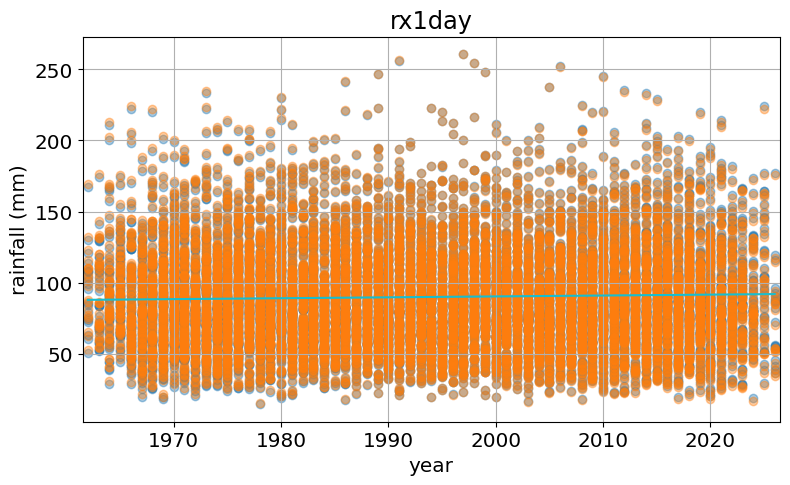

In [25]:
fig, ax = plt.subplots(figsize=[9, 5])
years = da_model_stacked['time'].dt.year.values
unique_years = np.unique(da_model_stacked.time.dt.year.values)
plt.scatter(years, da_model_stacked.values, marker='o', color='tab:blue', alpha=0.4, label='raw data')
plt.plot(unique_years, linear_data_model, color='tab:cyan')
plt.scatter(years, da_model_detrended_stacked.values, marker='o', color='tab:orange', alpha=0.4, label='detrended data')
plt.xlim(unique_years[0] - 0.5, unique_years[-1] + 0.5)
plt.title('rx1day')
plt.ylabel('rainfall (mm)')
plt.xlabel('year')
#plt.legend()
plt.grid()

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


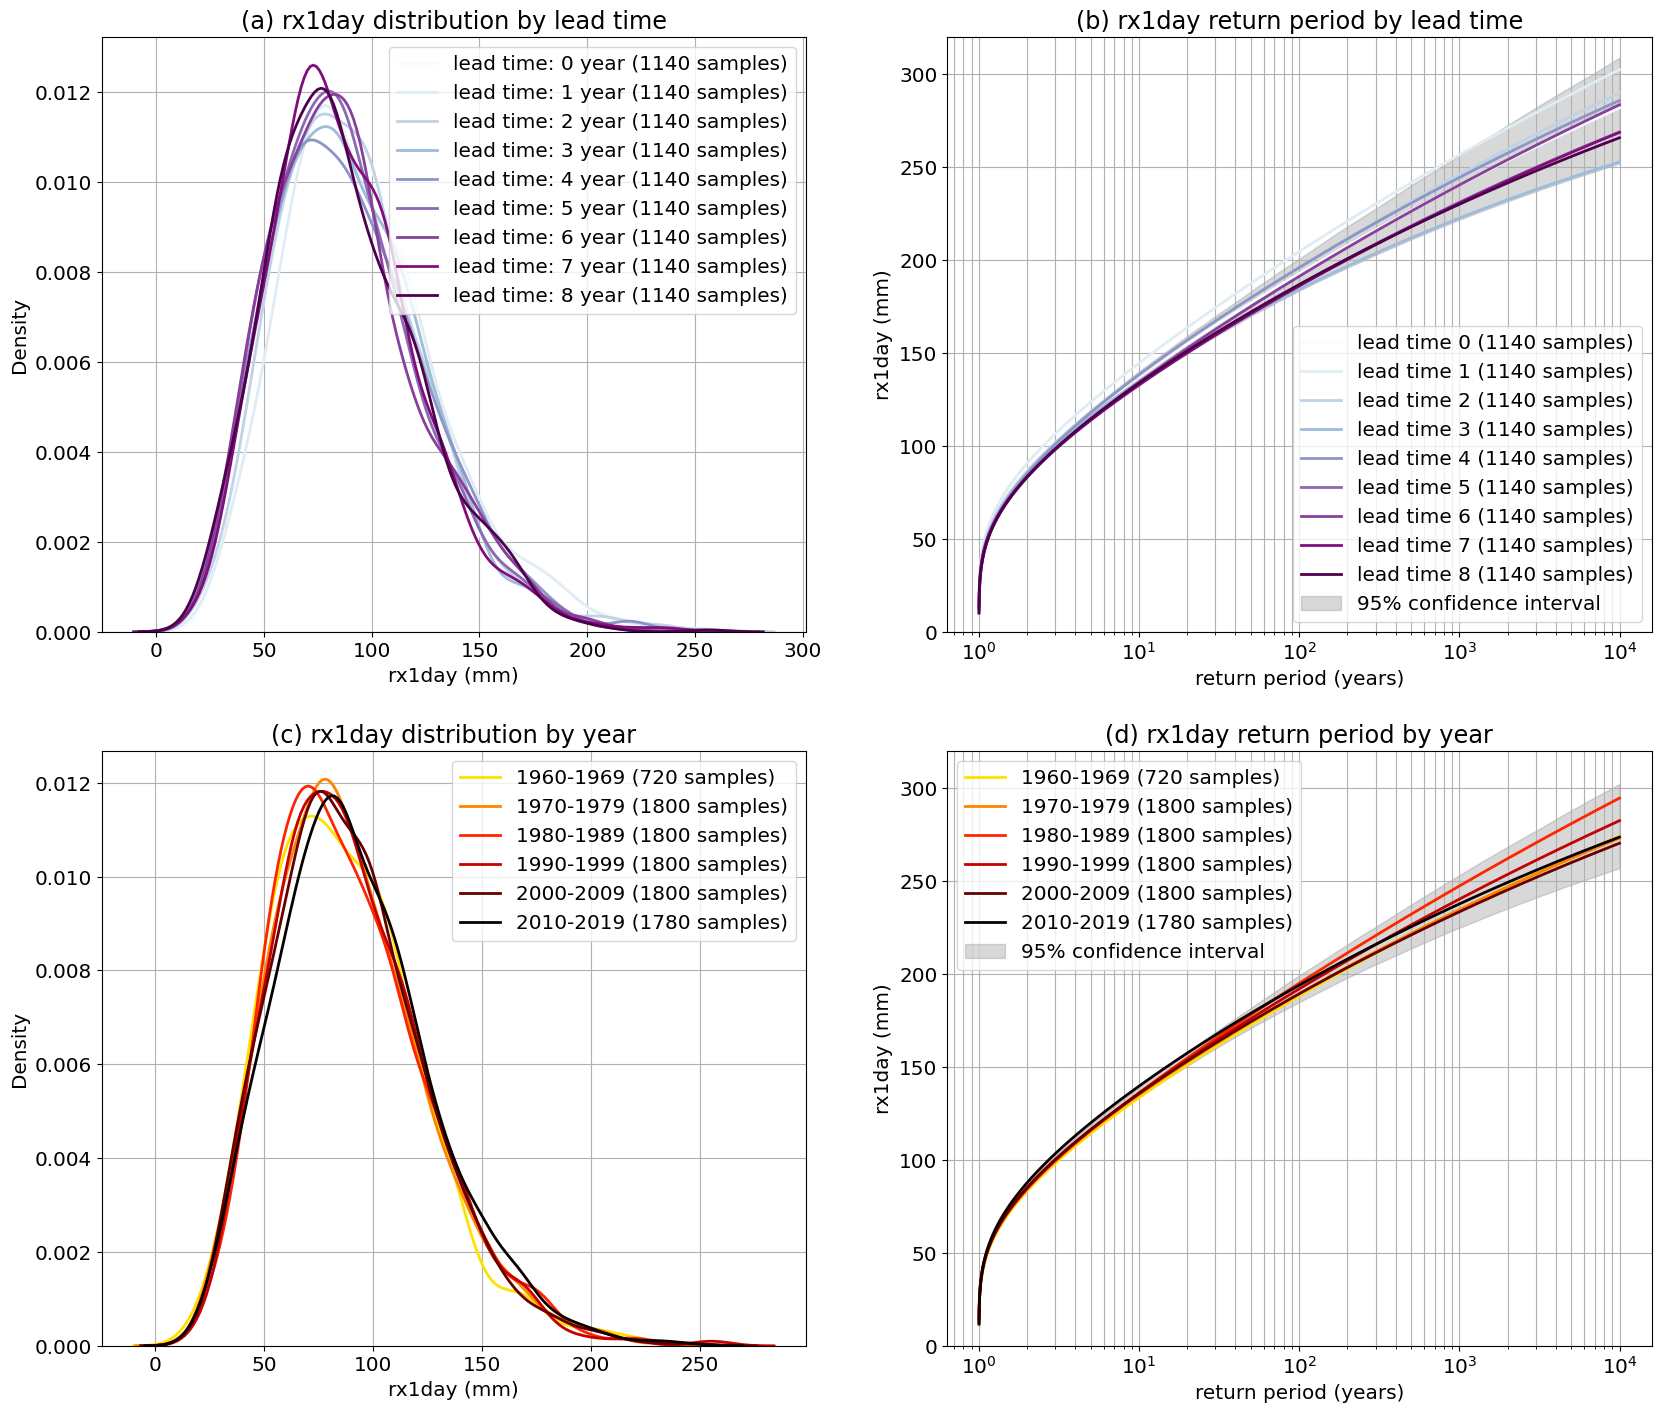

In [26]:
stability.create_plot(
    da_model,
    'rx1day',
    [1960, 1970, 1980, 1990, 2000, 2010],
    uncertainty=True,
    return_method='gev',
    units='rx1day (mm)',
    ylim=(0, 320),
)

/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/irv033/opt/anaconda3/envs/unseen/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:4653: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


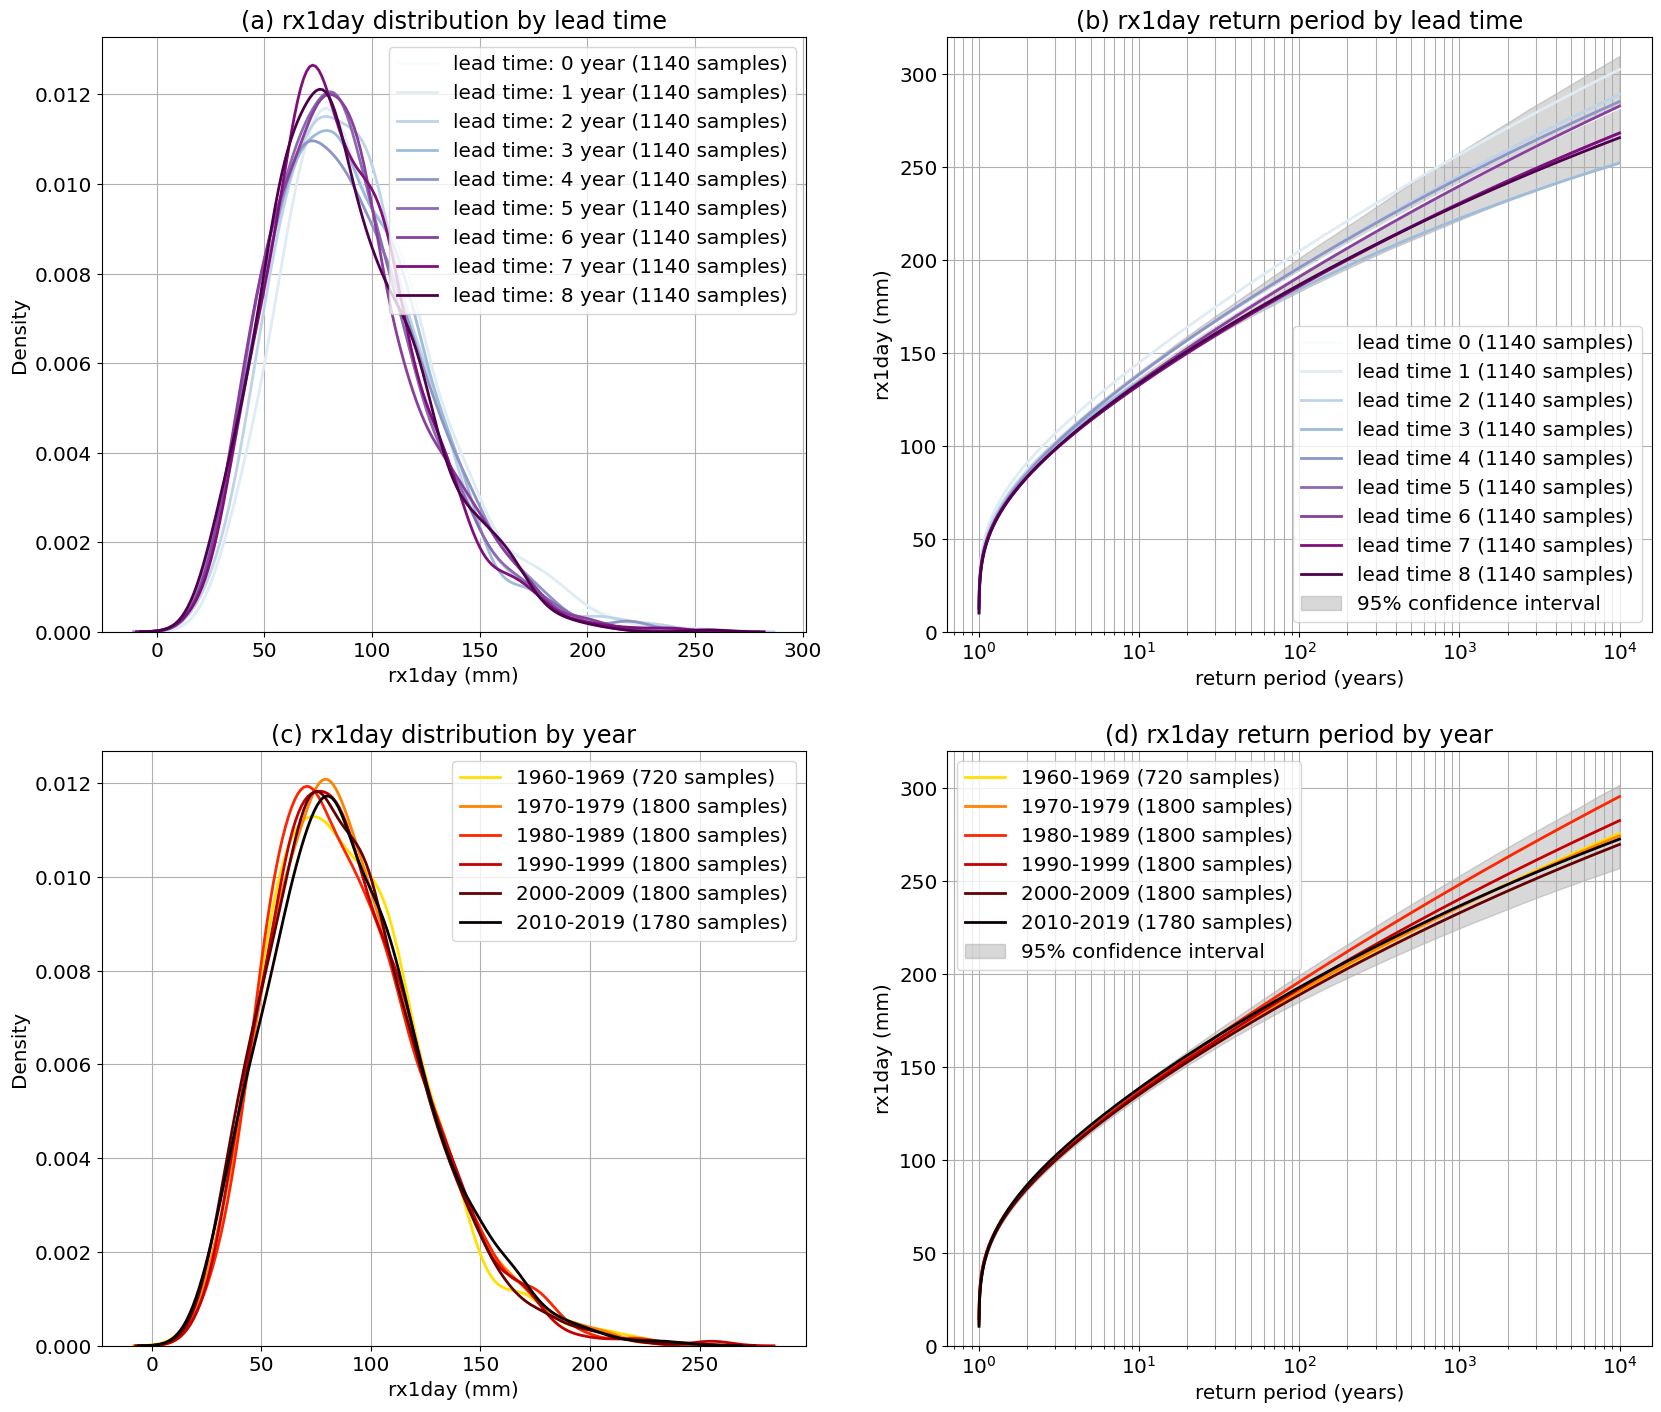

In [27]:
stability.create_plot(
    da_model_detrended,
    'rx1day',
    [1960, 1970, 1980, 1990, 2000, 2010],
    uncertainty=True,
    return_method='gev',
    units='rx1day (mm)',
    ylim=(0, 320),
)

In [28]:
gev_shape_model_detrended, gev_loc_model_detrended, gev_scale_model_detrended = eva.fit_gev(da_model_detrended_stacked.values)
print(f'Shape parameter: {gev_shape_model_detrended:.2f}')
print(f'Location parameter: {gev_loc_model_detrended:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended:.2f}')

Shape parameter: 0.07
Location parameter: 74.62
Scale parameter: 29.65


### Mean correction

#### Additive

In [29]:
bias_mean_add = bias_correction.get_bias(
    da_model_detrended,
    da_obs_detrended,
    'additive',
    time_rounding='A',
    time_period=['1972-01-01', '2018-12-31']
)

In [30]:
da_model_detrended_bc_mean_add = bias_correction.remove_bias(da_model_detrended, bias_mean_add, 'additive')

In [31]:
da_model_detrended_bc_mean_add = da_model_detrended_bc_mean_add.compute()

In [32]:
da_model_detrended_bc_mean_add_stacked = da_model_detrended_bc_mean_add.dropna('lead_time').stack(
    {'sample': ['ensemble', 'init_date', 'lead_time']}
)

In [33]:
gev_shape_model_detrended_bc_mean_add, gev_loc_model_detrended_bc_mean_add, gev_scale_model_detrended_bc_mean_add = eva.fit_gev(da_model_detrended_bc_mean_add_stacked.values)
print(f'Shape parameter: {gev_shape_model_detrended_bc_mean_add:.2f}')
print(f'Location parameter: {gev_loc_model_detrended_bc_mean_add:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended_bc_mean_add:.2f}')

Shape parameter: 0.07
Location parameter: 32.16
Scale parameter: 29.65


#### Multiplicative

In [34]:
bias_mean_mulc = bias_correction.get_bias(
    da_model_detrended,
    da_obs_detrended,
    'multiplicative',
    time_rounding='A',
    time_period=['1972-01-01', '2018-12-31']
)

In [35]:
da_model_detrended_bc_mean_mulc = bias_correction.remove_bias(da_model_detrended, bias_mean_mulc, 'multiplicative')
da_model_detrended_bc_mean_mulc = da_model_detrended_bc_mean_mulc.compute()

In [36]:
da_model_detrended_bc_mean_mulc_stacked = da_model_detrended_bc_mean_mulc.dropna('lead_time').stack(
    {'sample': ['ensemble', 'init_date', 'lead_time']}
)

In [37]:
gev_shape_model_detrended_bc_mean_mulc, gev_loc_model_detrended_bc_mean_mulc, gev_scale_model_detrended_bc_mean_mulc = eva.fit_gev(da_model_detrended_bc_mean_mulc_stacked.values)
print(f'Shape parameter: {gev_shape_model_detrended_bc_mean_mulc:.2f}')
print(f'Location parameter: {gev_loc_model_detrended_bc_mean_mulc:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended_bc_mean_mulc:.2f}')

Shape parameter: 0.07
Location parameter: 39.40
Scale parameter: 15.66


### Quantile correction

In [38]:
nquantiles = 10
quantile_array = xc.sdba.utils.equally_spaced_nodes(nquantiles)

In [39]:
quantile_array

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])

In [40]:
da_model_detrended_q = nbutils.quantile(
    da_model_detrended_stacked,
    quantile_array,
    ['sample']
)
# time_utils.select_time_period(da_model_stacked.copy(), ['1972-01-01', '2018-12-31'])

In [41]:
da_model_detrended_q.values

array([ 40.35734666,  54.57702454,  64.36546649,  73.04414443,
        81.02461715,  90.00903475,  99.88128081, 111.08127959,
       125.91450527, 153.92495601])

In [42]:
da_obs_detrended_q = nbutils.quantile(
    da_obs_detrended,
    quantile_array,
    ['time']
)
# time_utils.select_time_period(da_obs.copy(), ['1972-01-01', '2018-12-31']),

In [43]:
da_obs_detrended_q.values

array([27.15029633, 31.45535601, 37.29872847, 39.71348848, 43.21666928,
       45.99620307, 50.2926843 , 55.83447813, 64.04275015, 74.13060812])

In [44]:
bias_quantile_add = da_model_detrended_q.values - da_obs_detrended_q.values

In [45]:
bias_quantile_add_cubic_fit = np.polyfit(quantile_array, bias_quantile_add, 3)

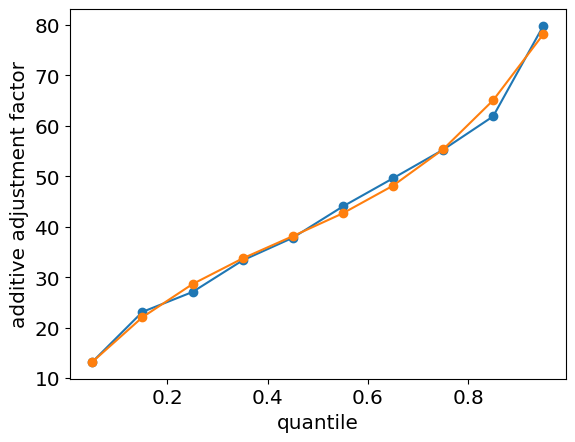

In [46]:
plt.plot(quantile_array, bias_quantile_add, marker='o')
cubic_data = np.polyval(bias_quantile_add_cubic_fit, quantile_array)
plt.plot(quantile_array, cubic_data, marker='o')
plt.xlabel('quantile')
plt.ylabel('additive adjustment factor')
plt.show()

In [47]:
bias_quantile_mulc = da_model_detrended_q.values / da_obs_detrended_q.values

In [48]:
bias_quantile_mulc_cubic_fit = np.polyfit(quantile_array, bias_quantile_mulc, 3)

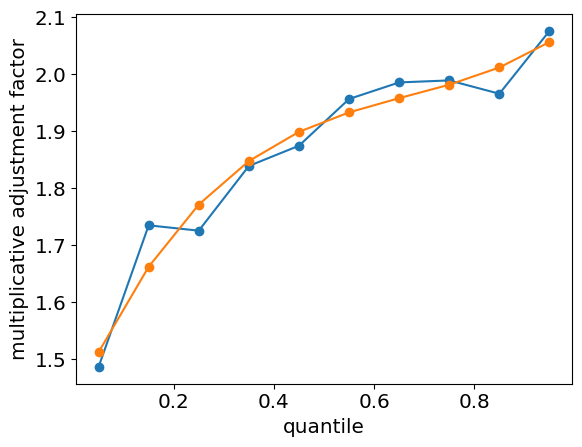

In [49]:
plt.plot(quantile_array, bias_quantile_mulc, marker='o')
cubic_data = np.polyval(bias_quantile_mulc_cubic_fit, quantile_array)
plt.plot(quantile_array, cubic_data, marker='o')
plt.xlabel('quantile')
plt.ylabel('multiplicative adjustment factor')
plt.show()

In [50]:
#def get_adjustment_factor(value, quantiles, adjustment_factors):
#    """Find the adjustment factor corresponding to the closest quantile."""
#
#    assert quantiles.shape == adjustment_factors.shape
#    
#    difference_array = np.absolute(quantiles - value)
#    index = difference_array.argmin()
#    adjustment_factor = adjustment_factors[index]
#
#    return adjustment_factor
#
#vget_adjustment_factor = np.vectorize(get_adjustment_factor, excluded=['quantiles', 'adjustment_factors'])


def get_smooth_adjustment_factor(value, data, af_cubic_fit):
    """Find the adjustment factor."""

    quantile = stats.percentileofscore(data, value) / 100
    af = np.polyval(af_cubic_fit, quantile)

    return af

vget_smooth_adjustment_factor = np.vectorize(get_smooth_adjustment_factor, excluded=['data', 'af_cubic_fit'])

#### Additive

In [51]:
af_add = vget_smooth_adjustment_factor(
    da_model_detrended_stacked.values,
    data=da_model_detrended_stacked.values,
    af_cubic_fit=bias_quantile_add_cubic_fit,
)

In [52]:
da_model_detrended_bc_quantile_add = da_model_detrended_stacked - af_add

In [53]:
gev_shape_model_detrended_bc_quantile_add, gev_loc_model_detrended_bc_quantile_add, gev_scale_model_detrended_bc_quantile_add = eva.fit_gev(da_model_detrended_bc_quantile_add.values)
print(f'Shape parameter: {gev_shape_model_detrended_bc_quantile_add:.2f}')
print(f'Location parameter: {gev_loc_model_detrended_bc_quantile_add:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended_bc_quantile_add:.2f}')

Shape parameter: 0.00
Location parameter: 40.19
Scale parameter: 12.69


#### Multiplicative

In [54]:
af_mulc = vget_smooth_adjustment_factor(
    da_model_detrended_stacked.values,
    data=da_model_detrended_stacked.values,
    af_cubic_fit=bias_quantile_mulc_cubic_fit,
)

In [55]:
da_model_detrended_bc_quantile_mulc = da_model_detrended_stacked / af_mulc

In [56]:
gev_shape_model_detrended_bc_quantile_mulc, gev_loc_model_detrended_bc_quantile_mulc, gev_scale_model_detrended_bc_quantile_mulc = eva.fit_gev(da_model_detrended_bc_quantile_mulc.values)
print(f'Shape parameter: {gev_shape_model_detrended_bc_quantile_mulc:.2f}')
print(f'Location parameter: {gev_loc_model_detrended_bc_quantile_mulc:.2f}')
print(f'Scale parameter: {gev_scale_model_detrended_bc_quantile_mulc:.2f}')

Shape parameter: 0.06
Location parameter: 40.53
Scale parameter: 12.58


## Comparison

In [57]:
def fidelity_tests(da_target):
    """Perform fidelity tests."""
    
    similarity_scores = similarity.similarity_tests(da_target, da_obs)
    print('KS score:', similarity_scores['ks_statistic'].values)
    print('KS p-value:', similarity_scores['ks_pval'].values)
    print('AD score:', similarity_scores['ad_statistic'].values)
    print('AD p-value:', similarity_scores['ad_pval'].values)

    moments.create_plot(
        da_model_detrended,
        da_obs_detrended,
        da_bc_fcst=da_target,
    )

In [58]:
xmax = np.max([da_model_detrended_stacked.values.max(), da_obs_detrended.values.max()]) + 1
xmin = np.min([da_model_detrended_stacked.values.min(), da_obs_detrended.values.min()]) - 1

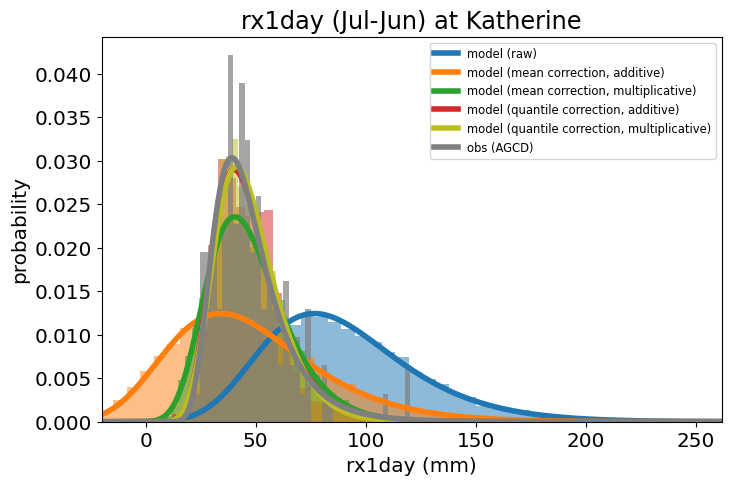

In [59]:
fig, ax = plt.subplots(figsize=[8, 5])
gev_xvals = np.arange(-20, 300, 0.5)

da_model_detrended_stacked.plot.hist(bins=40, density=True, color='tab:blue', alpha=0.5)
gev_pdf_model_detrended = gev.pdf(gev_xvals, gev_shape_model_detrended, gev_loc_model_detrended, gev_scale_model_detrended)
plt.plot(gev_xvals, gev_pdf_model_detrended, color='tab:blue', linewidth=4.0, label='model (raw)')

da_model_detrended_bc_mean_add_stacked.plot.hist(bins=40, density=True, color='tab:orange', alpha=0.5)
gev_pdf_model_detrended_bc_mean_add = gev.pdf(
    gev_xvals,
    gev_shape_model_detrended_bc_mean_add,
    gev_loc_model_detrended_bc_mean_add,
    gev_scale_model_detrended_bc_mean_add
)
plt.plot(
    gev_xvals,
    gev_pdf_model_detrended_bc_mean_add,
    color='tab:orange',
    linewidth=4.0,
    label='model (mean correction, additive)'
)

da_model_detrended_bc_mean_mulc_stacked.plot.hist(bins=40, density=True, color='tab:green', alpha=0.5)
gev_pdf_model_detrended_bc_mean_mulc = gev.pdf(
    gev_xvals,
    gev_shape_model_detrended_bc_mean_mulc,
    gev_loc_model_detrended_bc_mean_mulc,
    gev_scale_model_detrended_bc_mean_mulc
)
plt.plot(
    gev_xvals,
    gev_pdf_model_detrended_bc_mean_mulc,
    color='tab:green',
    linewidth=4.0,
    label='model (mean correction, multiplicative)'
)

da_model_detrended_bc_quantile_add.plot.hist(bins=40, density=True, color='tab:red', alpha=0.5)
gev_pdf_model_detrended_bc_quantile_add = gev.pdf(
    gev_xvals,
    gev_shape_model_detrended_bc_quantile_add,
    gev_loc_model_detrended_bc_quantile_add,
    gev_scale_model_detrended_bc_quantile_add
)
plt.plot(
    gev_xvals,
    gev_pdf_model_detrended_bc_quantile_add,
    color='tab:red',
    linewidth=4.0,
    label='model (quantile correction, additive)'
)

da_model_detrended_bc_quantile_mulc.plot.hist(bins=40, density=True, color='tab:olive', alpha=0.5)
gev_pdf_model_detrended_bc_quantile_mulc = gev.pdf(
    gev_xvals,
    gev_shape_model_detrended_bc_quantile_mulc,
    gev_loc_model_detrended_bc_quantile_mulc,
    gev_scale_model_detrended_bc_quantile_mulc
)
plt.plot(
    gev_xvals,
    gev_pdf_model_detrended_bc_quantile_mulc,
    color='tab:olive',
    linewidth=4.0,
    label='model (quantile correction, multiplicative)'
)

da_obs_detrended.plot.hist(bins=40, density=True, color='tab:gray', alpha=0.7)
gev_pdf_obs_detrended = gev.pdf(gev_xvals, gev_shape_obs_detrended, gev_loc_obs_detrended, gev_scale_obs_detrended)
plt.plot(gev_xvals, gev_pdf_obs_detrended, color='tab:gray', linewidth=4.0, label='obs (AGCD)')

plt.xlabel('rx1day (mm)')
plt.ylabel('probability')
plt.title(f'rx1day (Jul-Jun) at {location}')

plt.xlim(-20, xmax)
plt.legend(fontsize='small')
plt.savefig(f'rx1day_{location}_gevs.png', bbox_inches='tight', facecolor='white')
plt.show()

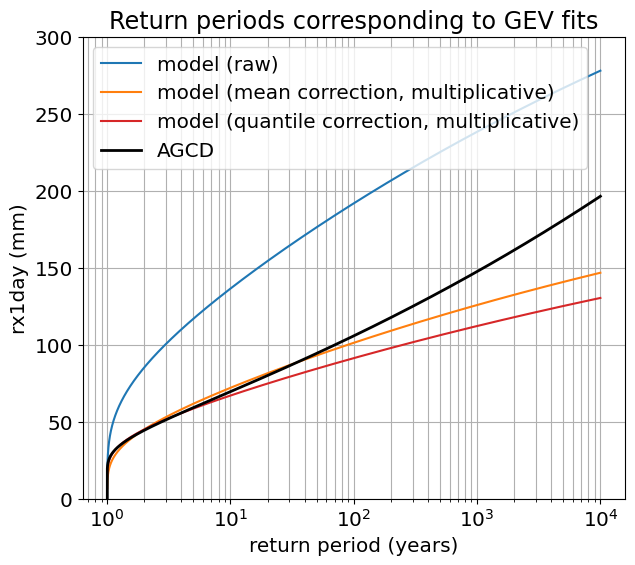

In [60]:
fig = plt.figure(figsize=[7, 6])
#ax1 = fig.add_subplot(211)
#ax2 = fig.add_subplot(212)
ax2 = fig.add_subplot(111)

#ax1.plot(gev_xvals, gev_pdf_model_detrended, color='tab:blue', label='model (raw)')
return_periods_model_detrended, return_values_model_detrended = stability.return_curve(
    da_model_detrended,
    'gev',
    params=[gev_shape_model_detrended, gev_loc_model_detrended, gev_scale_model_detrended],
)
ax2.plot(return_periods_model_detrended, return_values_model_detrended, label='model (raw)', color='tab:blue')

#ax1.plot(gev_xvals, gev_pdf_model_detrended_bc_mean_mulc, color='tab:orange', label='model (mean correction, multiplicative)')
return_periods_model_detrended_bc_mean_mulc, return_values_model_detrended_bc_mean_mulc = stability.return_curve(
    da_model_detrended_bc_mean_mulc,
    'gev',
    params=[gev_shape_model_detrended_bc_mean_mulc, gev_loc_model_detrended_bc_mean_mulc, gev_scale_model_detrended_bc_mean_mulc],
)
ax2.plot(
    return_periods_model_detrended_bc_mean_mulc,
    return_values_model_detrended_bc_mean_mulc,
    label='model (mean correction, multiplicative)',
    color='tab:orange'
)

#ax1.plot(gev_xvals, gev_pdf_model_detrended_bc_quantile_mulc, color='tab:red', label='model (quantile correction, multiplicative)')
return_periods_model_detrended_bc_quantile_mulc, return_values_model_detrended_bc_quantile_mulc = stability.return_curve(
    da_model_detrended_bc_quantile_mulc,
    'gev',
    params=[gev_shape_model_detrended_bc_quantile_mulc, gev_loc_model_detrended_bc_quantile_mulc, gev_scale_model_detrended_bc_quantile_mulc],
)
ax2.plot(
    return_periods_model_detrended_bc_quantile_mulc,
    return_values_model_detrended_bc_quantile_mulc,
    label='model (quantile correction, multiplicative)',
    color='tab:red'
)

#ax1.plot(gev_xvals, gev_pdf_obs_detrended, color='black', linewidth=2.0, label='AGCD')
return_periods_obs_detrended, return_values_obs_detrended = stability.return_curve(
    da_obs_detrended,
    'gev',
    params=[gev_shape_obs_detrended, gev_loc_obs_detrended, gev_scale_obs_detrended],
)
ax2.plot(return_periods_obs_detrended, return_values_obs_detrended, label='AGCD', color='black', linewidth=2.0)

#ax1.grid()
#ax1.set_xlabel('TXx (C)')
#ax1.set_ylabel('probability')
#ax1.axvline(agcd_max, color='0.5', linestyle='--')
#ax1.set_title('(a) GEV fit to data')
#ax1.set_xlim([0, 450])
#ax1.legend()

ax2.legend()
#ax2.axhline(agcd_max, color='0.5', linestyle='--')
ax2.set_xscale('log')
ax2.set_xlabel('return period (years)')
ax2.set_ylabel('rx1day (mm)')
ax2.set_title('Return periods corresponding to GEV fits')
ax2.set_ylim([0, 300])
ax2.grid(which='both')
plt.savefig(f'rx1day_{location}_return_curves.png', bbox_inches='tight', facecolor='white')
plt.show()

### Raw data

In [61]:
similarity_ds = similarity.similarity_tests(da_model_detrended, da_obs_detrended)
print('KS score:', similarity_ds['ks_statistic'].values)
print('KS p-value:', similarity_ds['ks_pval'].values)
print('AD score:', similarity_ds['ad_statistic'].values)
print('AD p-value:', similarity_ds['ad_pval'].values)

KS score: 0.6194718
KS p-value: 1e-45
AD score: 167.3451
AD p-value: 0.001


### Additive - mean correction

KS score: 0.2302073
KS p-value: 3.6306956e-06
AD score: 15.925646
AD p-value: 0.001


INFO:root:mean: Obs = 47.90504455566388, Model 95% CI =83.46863625423211 to 96.50973363756803
INFO:root:standard deviation: Obs = 17.30361181846401, Model 95% CI =29.797428089312188 to 39.8503537659562
INFO:root:skew: Obs = 1.5957395904422826, Model 95% CI =0.24231912792900312 to 1.278752193058571
INFO:root:kurtosis: Obs = 3.9627037167356107, Model 95% CI =-0.6052688286873944 to 3.0389393577708788
INFO:root:GEV shape: Obs = -0.0690679643320201, Model 95% CI =-0.04390493856606116 to 0.2069493818369282
INFO:root:GEV location: Obs = 40.01068449094611, Model 95% CI =68.95625811774565 to 81.4339107718913
INFO:root:GEV scale: Obs = 12.153049415078883, Model 95% CI =25.584662167387307 to 33.53702940552628
INFO:root:mean: Obs = 47.90504455566388, Bias corrected model 95% CI =41.36133220069895 to 53.405091026788845
INFO:root:standard deviation: Obs = 17.30361181846401, Bias corrected model 95% CI =29.878865406230744 to 39.887554486816526
INFO:root:skew: Obs = 1.5957395904422826, Bias corrected 

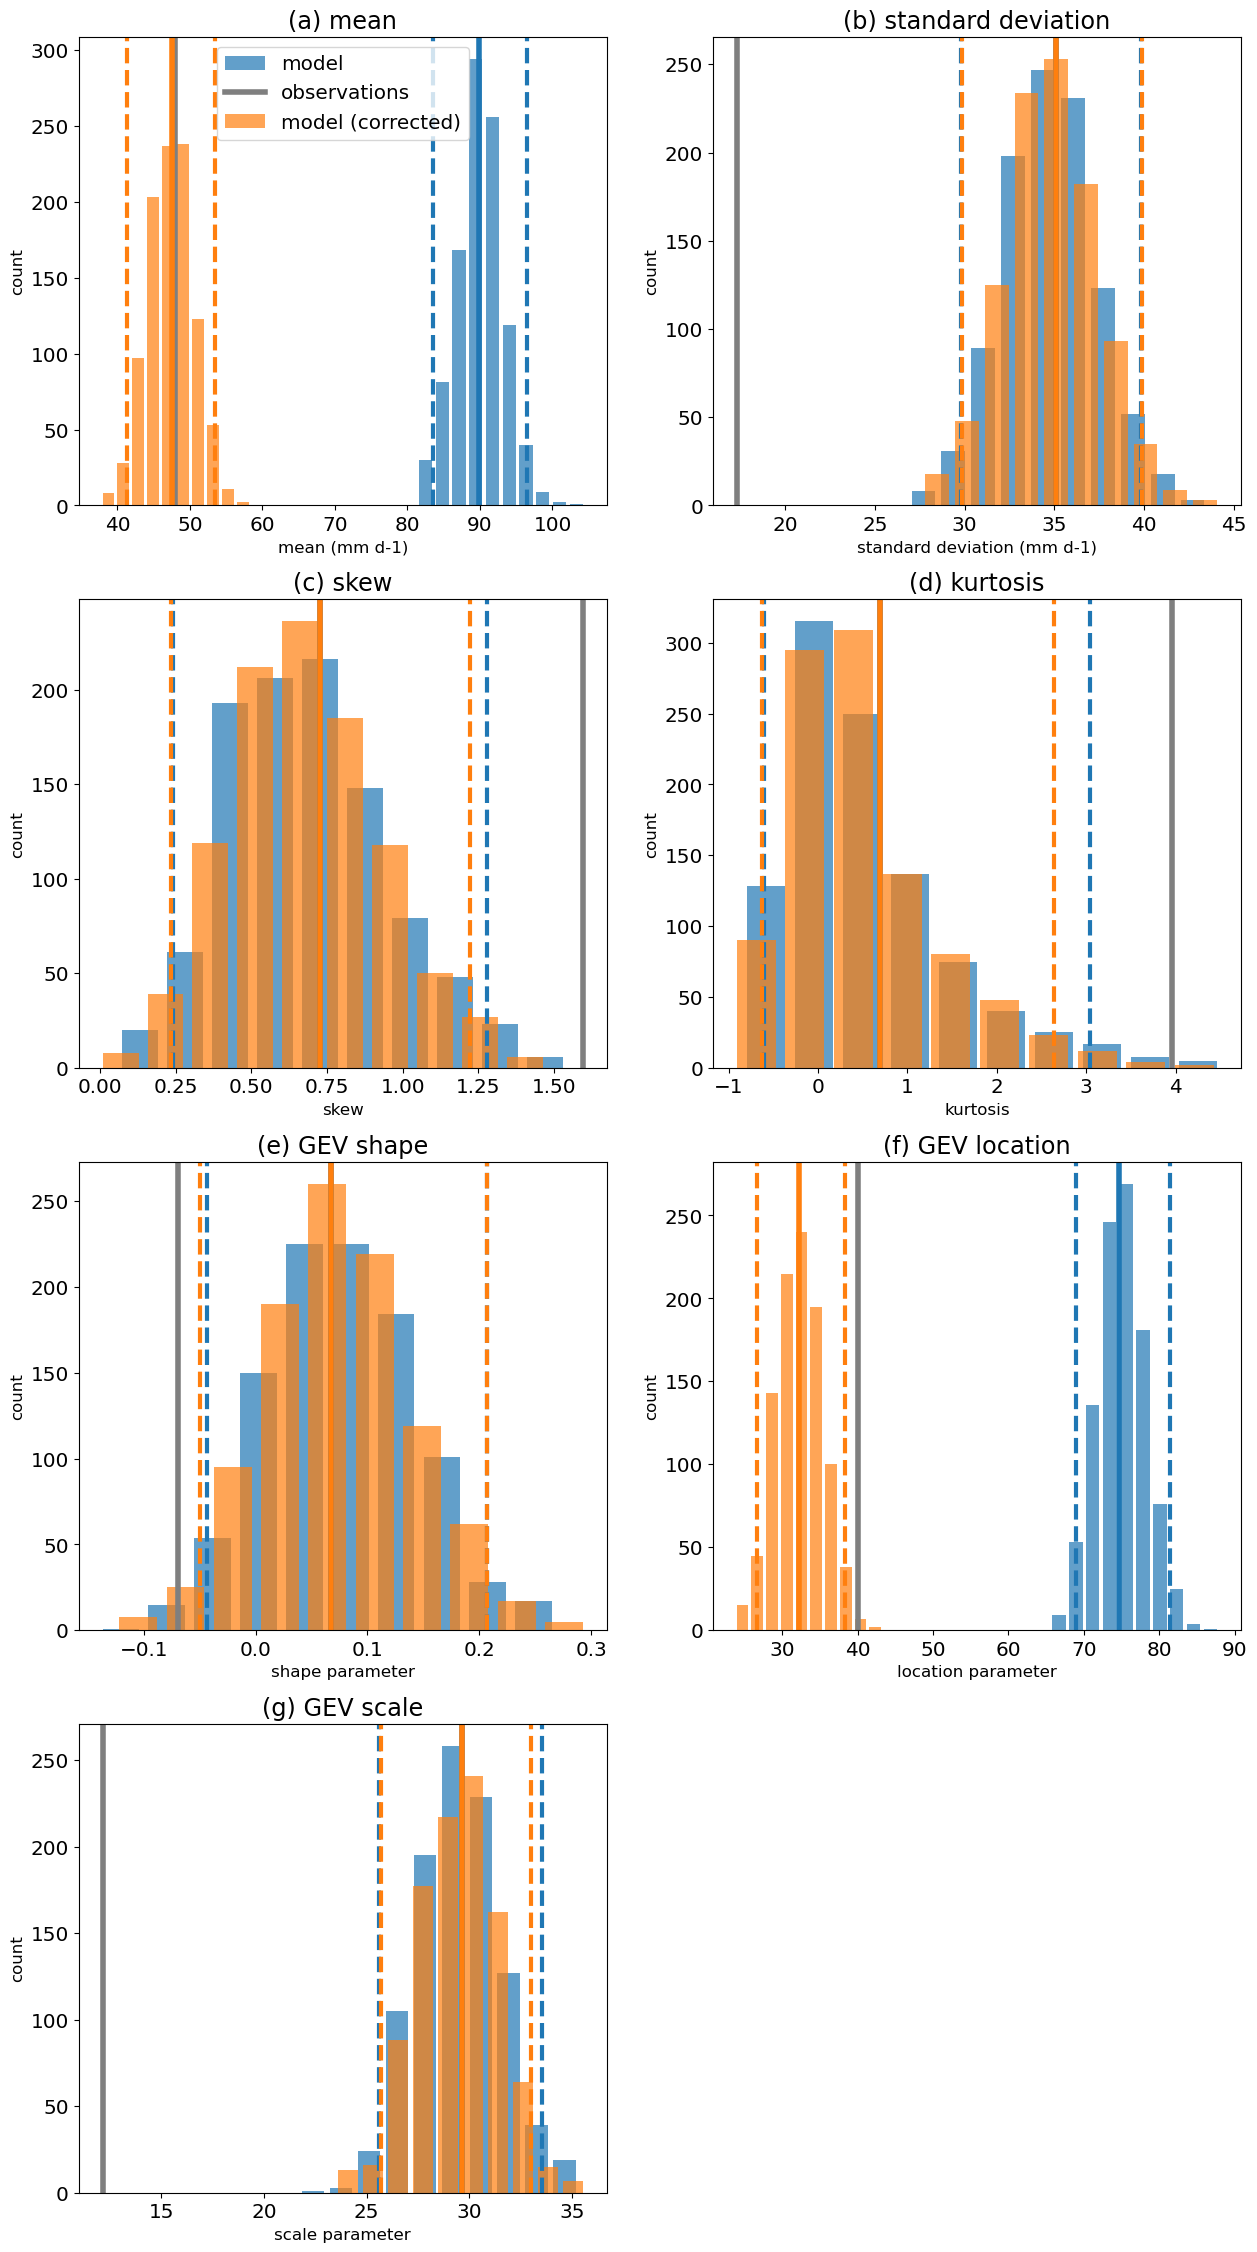

In [62]:
fidelity_tests(da_model_detrended_bc_mean_add)

### Multiplicative - mean correction

KS score: 0.13300052
KS p-value: 0.024203228
AD score: 1.8714212
AD p-value: 0.054976296


INFO:root:mean: Obs = 47.90504455566388, Model 95% CI =83.7357478193991 to 96.0463208757852
INFO:root:standard deviation: Obs = 17.30361181846401, Model 95% CI =29.542621566752725 to 39.61600703713085
INFO:root:skew: Obs = 1.5957395904422826, Model 95% CI =0.28335524396714373 to 1.1945825586727554
INFO:root:kurtosis: Obs = 3.9627037167356107, Model 95% CI =-0.5387606509785092 to 2.792198492051815
INFO:root:GEV shape: Obs = -0.0690679643320201, Model 95% CI =-0.04863994998439997 to 0.1929057541784224
INFO:root:GEV location: Obs = 40.01068449094611, Model 95% CI =69.10903116058539 to 80.78213928817809
INFO:root:GEV scale: Obs = 12.153049415078883, Model 95% CI =25.160607795638246 to 33.60384552428896
INFO:root:mean: Obs = 47.90504455566388, Bias corrected model 95% CI =44.199067596514666 to 50.84015218937237
INFO:root:standard deviation: Obs = 17.30361181846401, Bias corrected model 95% CI =15.724589554453596 to 21.215417276104088
INFO:root:skew: Obs = 1.5957395904422826, Bias corrected 

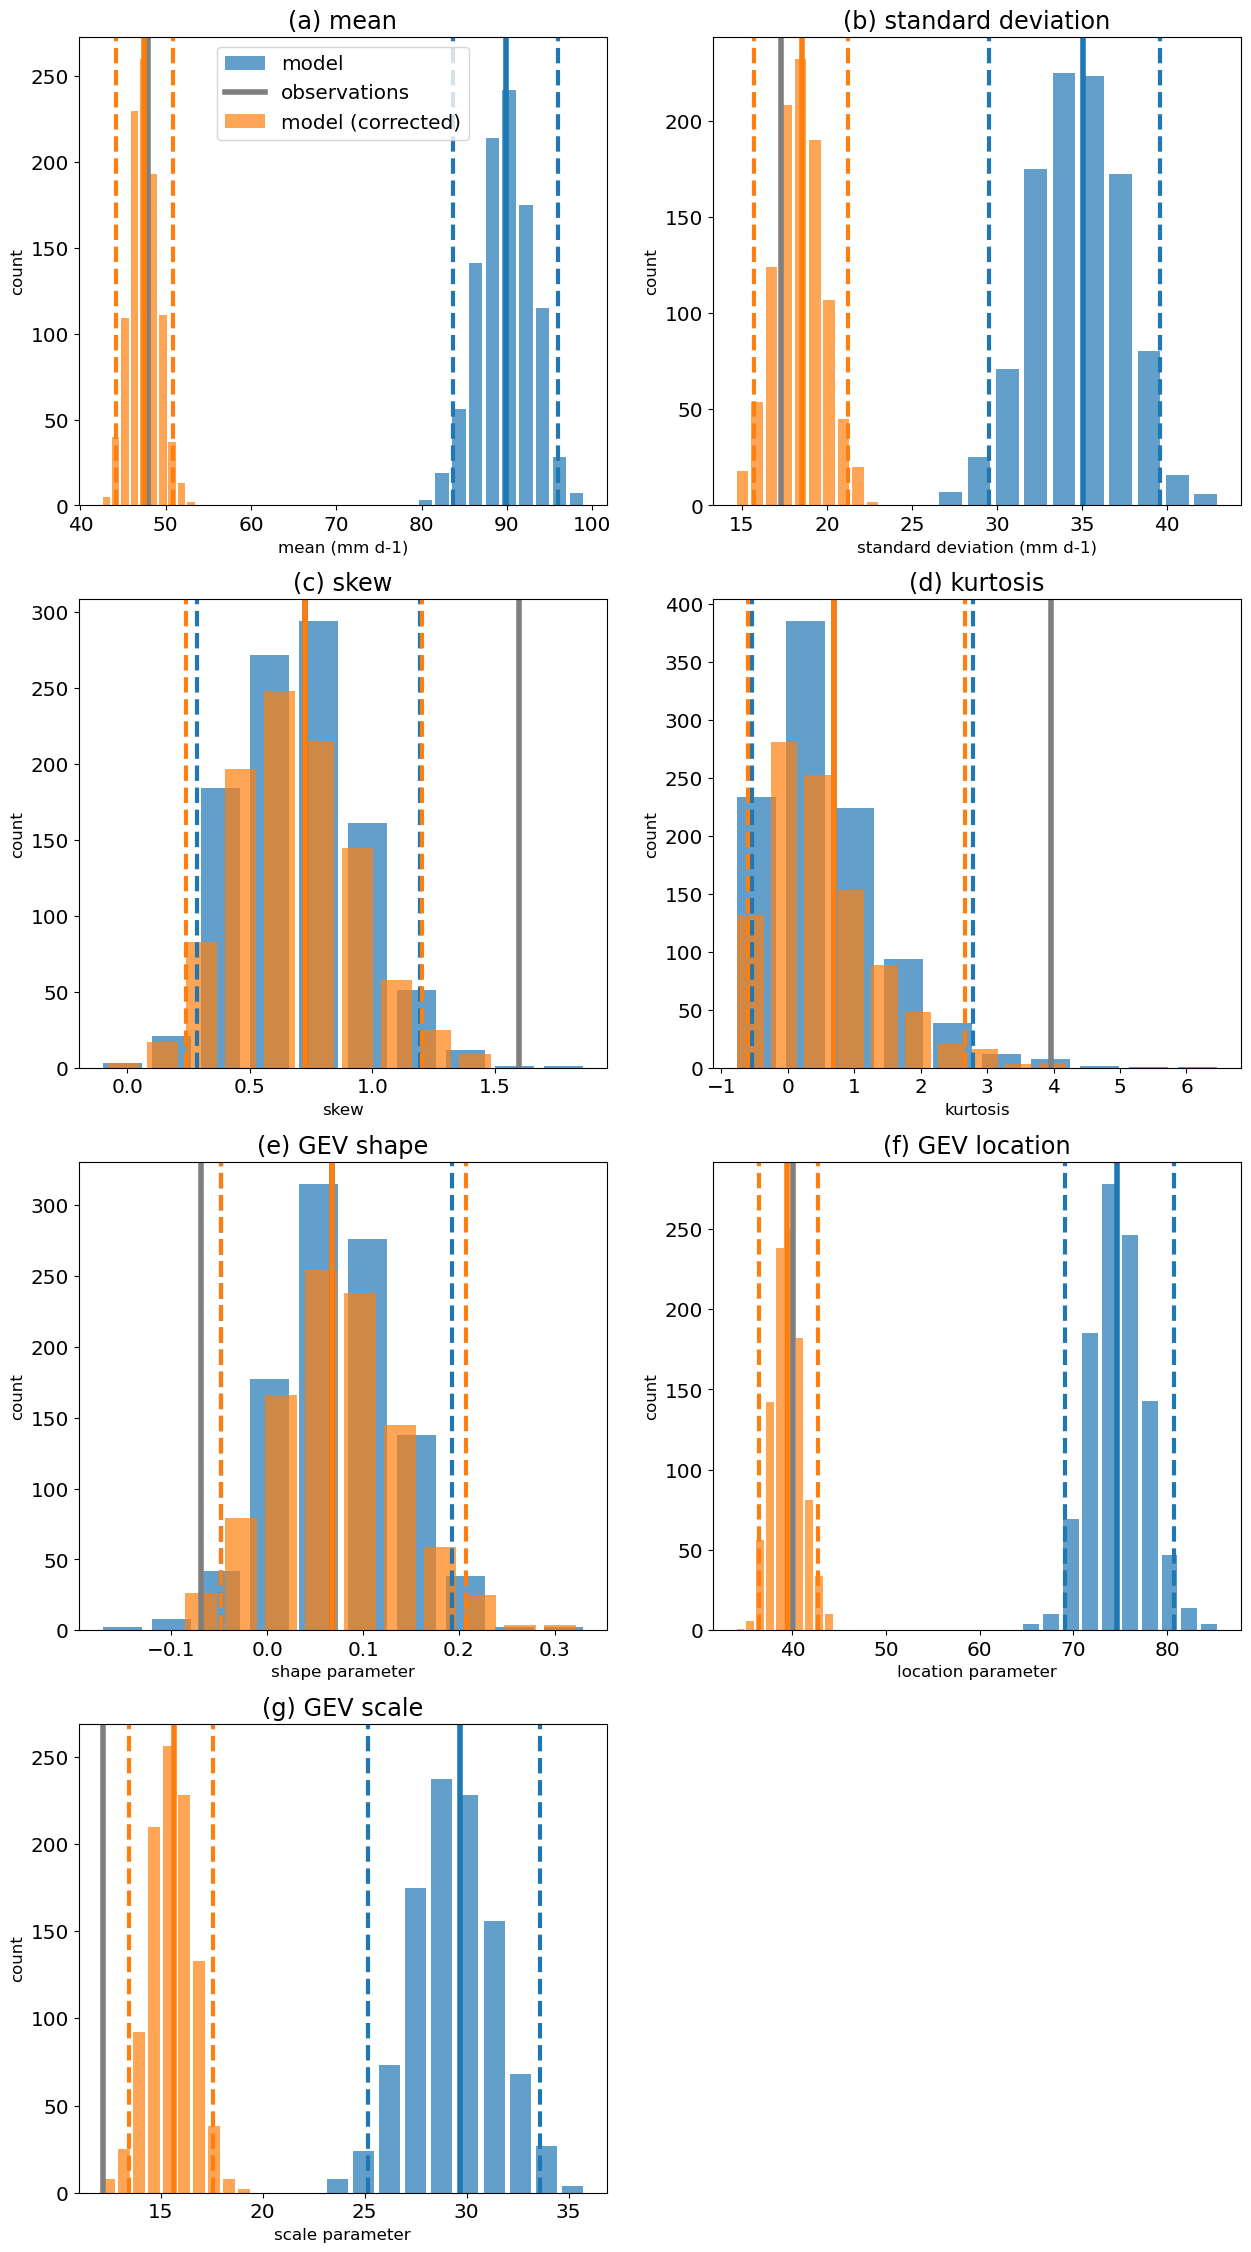

In [63]:
fidelity_tests(da_model_detrended_bc_mean_mulc)

### Additive - quantile correction

KS score: 0.13149813
KS p-value: 0.02671028
AD score: 2.380894
AD p-value: 0.03421497


INFO:root:mean: Obs = 47.90504455566388, Model 95% CI =84.09419892074612 to 96.30340385125378
INFO:root:standard deviation: Obs = 17.30361181846401, Model 95% CI =30.040548333485358 to 39.97494887488146
INFO:root:skew: Obs = 1.5957395904422826, Model 95% CI =0.24291184013631162 to 1.2394560982894343
INFO:root:kurtosis: Obs = 3.9627037167356107, Model 95% CI =-0.5852787443720534 to 2.856687486129934
INFO:root:GEV shape: Obs = -0.0690679643320201, Model 95% CI =-0.04979559359269526 to 0.20850180758629933
INFO:root:GEV location: Obs = 40.01068449094611, Model 95% CI =69.05091539847976 to 80.5955682691628
INFO:root:GEV scale: Obs = 12.153049415078883, Model 95% CI =25.70393715925252 to 33.66341783763929
INFO:root:mean: Obs = 47.90504455566388, Bias corrected model 95% CI =44.57631731371491 to 50.52630772051508
INFO:root:standard deviation: Obs = 17.30361181846401, Bias corrected model 95% CI =12.874964347466497 to 20.583388210139933
INFO:root:skew: Obs = 1.5957395904422826, Bias corrected 

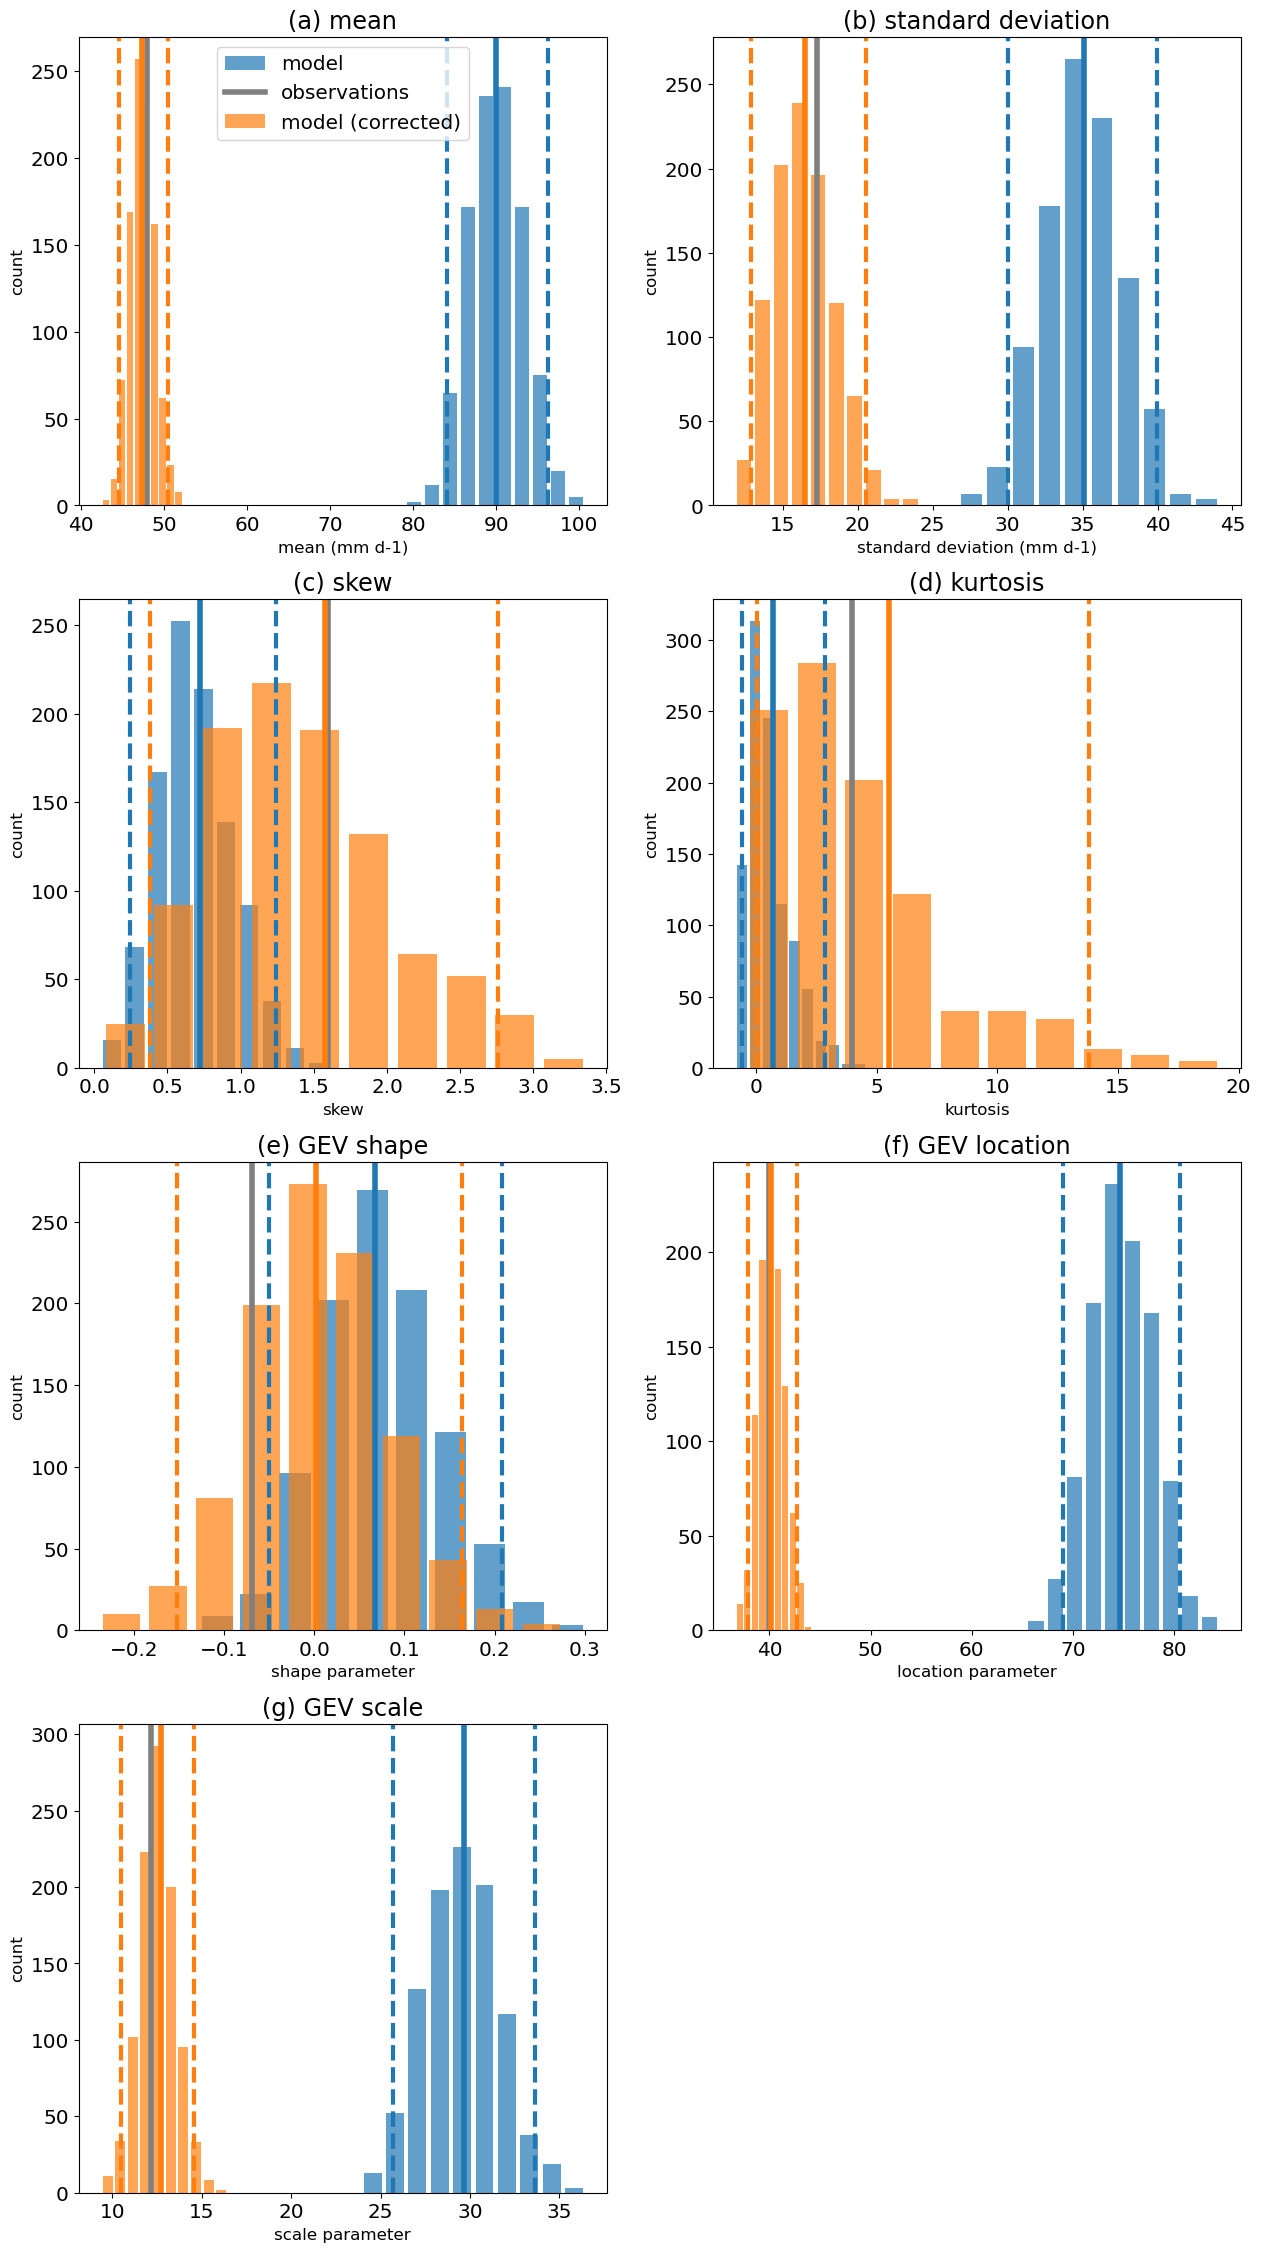

In [64]:
fidelity_tests(da_model_detrended_bc_quantile_add.unstack())

### Multiplicative - quantile correction

KS score: 0.11321495
KS p-value: 0.08099611
AD score: 2.330529
AD p-value: 0.03584214


INFO:root:mean: Obs = 47.90504455566388, Model 95% CI =83.63727241680009 to 96.27722417783151
INFO:root:standard deviation: Obs = 17.30361181846401, Model 95% CI =29.552149232601003 to 39.996556917671974
INFO:root:skew: Obs = 1.5957395904422826, Model 95% CI =0.2388389610891693 to 1.2382803829467839
INFO:root:kurtosis: Obs = 3.9627037167356107, Model 95% CI =-0.5961251839786949 to 2.725495777825446
INFO:root:GEV shape: Obs = -0.0690679643320201, Model 95% CI =-0.04611257485988058 to 0.20441691061009493
INFO:root:GEV location: Obs = 40.01068449094611, Model 95% CI =69.12356164165323 to 80.95355570176689
INFO:root:GEV scale: Obs = 12.153049415078883, Model 95% CI =25.387986474329438 to 33.63631901586766
INFO:root:mean: Obs = 47.90504455566388, Bias corrected model 95% CI =44.755655136589326 to 49.806474218971296
INFO:root:standard deviation: Obs = 17.30361181846401, Bias corrected model 95% CI =12.744358367492907 to 17.288595995183723
INFO:root:skew: Obs = 1.5957395904422826, Bias correc

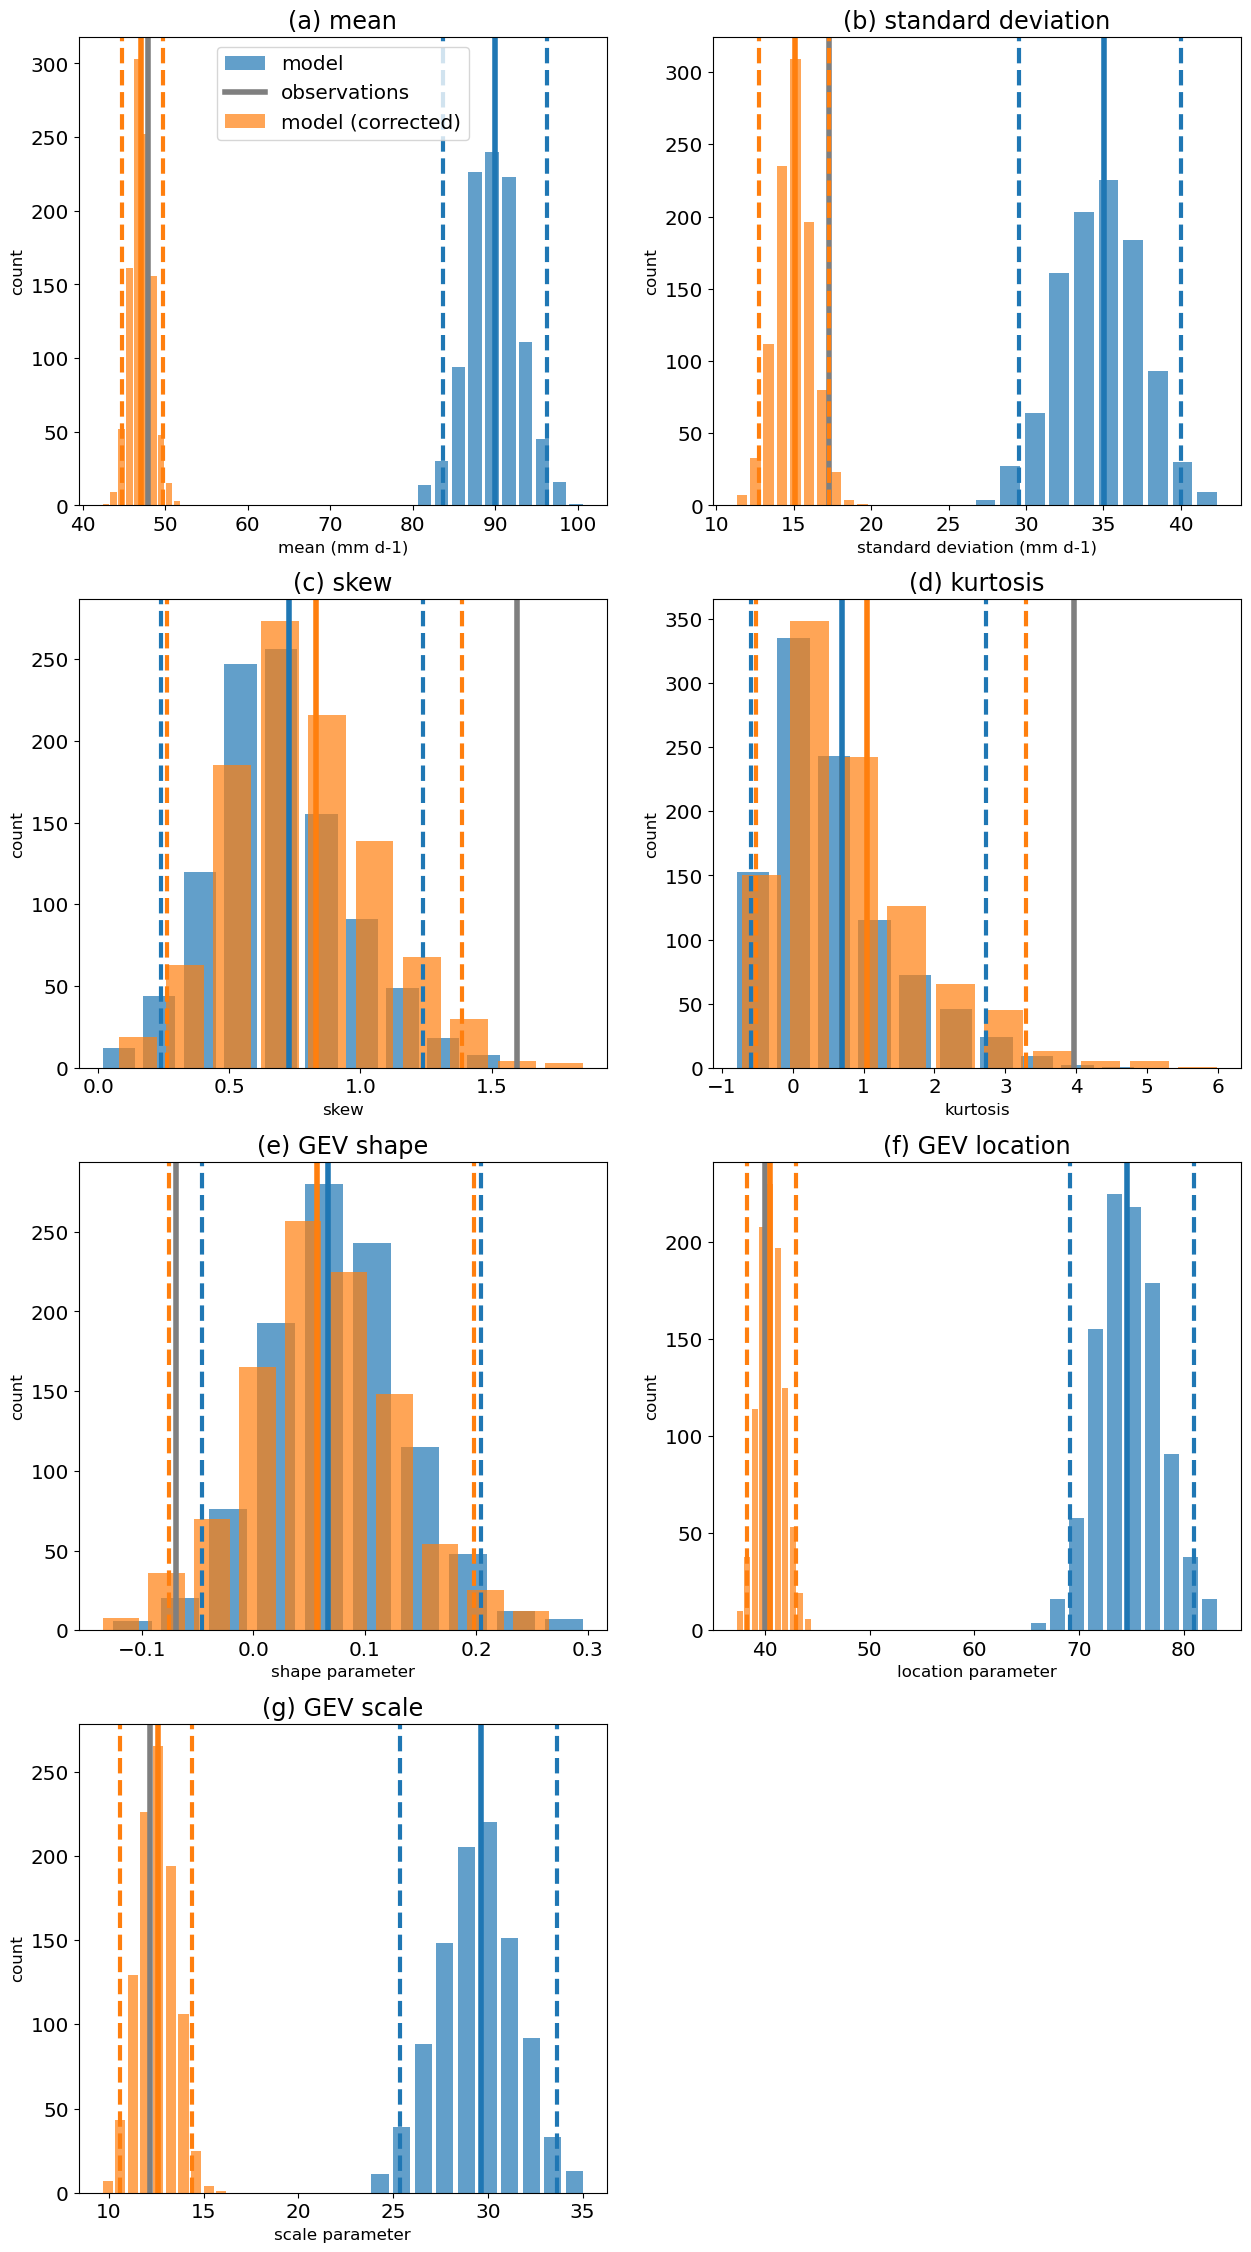

In [65]:
fidelity_tests(da_model_detrended_bc_quantile_mulc.unstack())